# Importazione librerie

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Lettura dati Bitcoin

In [64]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [65]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
# data_inizio = '2021-05-01'
# data_fine = '2021-07-31'

# Periodo personale
data_inizio = '2021-02-01'
data_fine = '2021-07-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-02-01,27790.582031
1,2021-02-02,29501.521484
2,2021-02-03,31119.447266
3,2021-02-04,30859.554688
4,2021-02-05,31658.248047
...,...,...
146,2021-06-27,29013.742188
147,2021-06-28,28866.302734
148,2021-06-29,30139.980469
149,2021-06-30,29555.054688


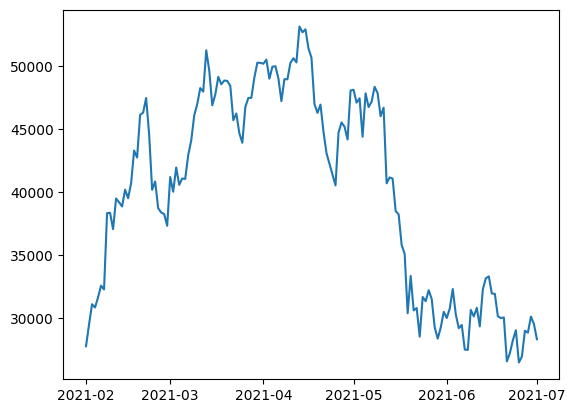

In [66]:
plt.plot(dati['Timestamp'], dati['Price'])

# Strategia

In [67]:
# Funzioni di supporto
def aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS):
    return (1 - perc_TS) * prezzo + perc_TS * prezzo_TS

def quanto_acquistare(liquidità_attuale):
    return 0.2 * liquidità_attuale

def quanto_vendere(bitcoin_posseduti):
    return bitcoin_posseduti

In [68]:
def strategia_trading(
    dati, 
    liquidità_iniziale, 
    bitcoin_iniziali, 
    perc_primo_acquisto, 
    perc_TS, 
    perc_TS_inverso_setting
):

    # Dati iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    prezzo_TS = None
    prezzo_TS_inverso = None
    prezzo_minimo = None

    # Variabili di supporto
    prezzo_medio_acquisti = 0  # Media pesata dei prezzi degli acquisti
    quantità_acquisti = 0  # Quantità totale di BTC acquistati nella scia attuale
    valore_totale_acquisti = 0  # Valore totale degli acquisti effettuati
    in_scia_acquisti = False  # Flag per controllare se siamo in una scia di acquisti
    ultima_azione = "-"
    oltre_TS = False

    # Lista per registrare le transazioni
    transazioni = []

    # Itera sui dati
    for _, row in dati.iterrows():
        prezzo = row["Price"]
        timestamp = row["Timestamp"]
        azione = "-"
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0

        # Aggiorna il prezzo minimo nella scia corrente
        if in_scia_acquisti:
            if prezzo_minimo is None or prezzo < prezzo_minimo:
                prezzo_minimo = prezzo
                prezzo_TS_inverso = min(
                    prezzo * (1 + perc_TS_inverso_setting),
                    prezzo_medio_acquisti
                )

        # Controlla se l'acquisto è un "primo acquisto"
        if ultima_azione == "Vendita" or ultima_azione == "-":
            # Primo acquisto
            quantità_acquisto = perc_primo_acquisto * liquidità / prezzo
            liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
            liquidità -= liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = quantità_acquisto
            bitcoin += bitcoin_comprati_o_venduti
            prezzo_medio_acquisti = prezzo
            valore_totale_acquisti = quantità_acquisto * prezzo
            quantità_acquisti = quantità_acquisto
            prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS)
            prezzo_minimo = prezzo
            prezzo_TS_inverso = min(prezzo_minimo * (1 + perc_TS_inverso_setting), prezzo_medio_acquisti) # in realtà al primo acquisto è ovvio che venga uguale a prezzo_medio_acquisti, quindi il calcolo del minimo è superfluo
            in_scia_acquisti = True
            ultima_azione = "Acquisto"
            azione = "Acquisto"

        elif in_scia_acquisti:
            # Controlla se effettuare un acquisto in scia
            if prezzo < prezzo_medio_acquisti:
                if prezzo < prezzo_TS and prezzo >= prezzo_TS_inverso:
                    # Acquisto in scia
                    quantità_acquisto = quanto_acquistare(liquidità) / prezzo
                    liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
                    liquidità -= liquidità_spesa_o_guadagnata
                    bitcoin_comprati_o_venduti = quantità_acquisto
                    bitcoin += bitcoin_comprati_o_venduti
                    valore_totale_acquisti += liquidità_spesa_o_guadagnata
                    quantità_acquisti += quantità_acquisto
                    prezzo_medio_acquisti = valore_totale_acquisti / quantità_acquisti
                    prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS)
                    azione = "Acquisto"

        # Controlla se effettuare una vendita
        if prezzo > prezzo_TS:
            prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
            oltre_TS = True
        elif oltre_TS:
            # Vendita
            quantità_vendita = quanto_vendere(bitcoin)
            liquidità_spesa_o_guadagnata = quantità_vendita * prezzo
            liquidità += liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = -quantità_vendita
            bitcoin += bitcoin_comprati_o_venduti
            azione = "Vendita"
            prezzo_TS = None
            prezzo_TS_inverso = None
            prezzo_minimo = None
            prezzo_medio_acquisti = 0
            quantità_acquisti = 0
            valore_totale_acquisti = 0
            in_scia_acquisti = False
            ultima_azione = "Vendita"
            oltre_TS = False

        # Valore totale del portafoglio
        valore_totale_portafoglio = liquidità + bitcoin * prezzo

        # Registra la transazione
        transazioni.append({
            "timestamp": timestamp,
            "prezzo": prezzo,
            "prezzo_TS": prezzo_TS,
            "prezzo_TS_inverso": prezzo_TS_inverso,
            "ultima_azione": ultima_azione,
            "azione": azione,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti,
            "liquidità_posseduta": liquidità,
            "bitcoin_posseduti": bitcoin,
            "valore_totale_portafoglio": valore_totale_portafoglio,
        })

    # Converti la lista di transazioni in un dataframe
    df_transazioni = pd.DataFrame(transazioni)
    return df_transazioni

In [69]:
df_transazioni = strategia_trading(
    dati,
    liquidità_iniziale=0.01,
    bitcoin_iniziali=0.02478146,
    perc_primo_acquisto=0.1,
    perc_TS=0,
    perc_TS_inverso_setting=0.05
)

df_transazioni

,timestamp,prezzo,prezzo_TS,prezzo_TS_inverso,ultima_azione,azione,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2021-02-01,27790.582031,27790.582031,27790.582031,Acquisto,Acquisto,0.001000,3.598341e-08,0.009000,0.024781,688.701197
1,2021-02-02,29501.521484,29501.521484,27790.582031,Acquisto,-,0.000000,0.000000e+00,0.009000,0.024781,731.100836
2,2021-02-03,31119.447266,31119.447266,27790.582031,Acquisto,-,0.000000,0.000000e+00,0.009000,0.024781,771.195457
3,2021-02-04,30859.554688,NaN,NaN,Vendita,Vendita,764.745931,-2.478150e-02,764.754931,0.000000,764.754931
4,2021-02-05,31658.248047,31658.248047,31658.248047,Acquisto,Acquisto,76.475493,2.415658e-03,688.279437,0.002416,764.754931
...,...,...,...,...,...,...,...,...,...,...,...
146,2021-06-27,29013.742188,29265.597942,27827.983887,Acquisto,Acquisto,90.658611,3.124678e-03,362.634444,0.014499,783.315359
147,2021-06-28,28866.302734,29206.625417,27827.983887,Acquisto,Acquisto,72.526889,2.512510e-03,290.107555,0.017012,781.177580
148,2021-06-29,30139.980469,30139.980469,27827.983887,Acquisto,-,0.000000,0.000000e+00,290.107555,0.017012,802.845231
149,2021-06-30,29555.054688,NaN,NaN,Vendita,Vendita,502.786990,-1.701188e-02,792.894545,0.000000,792.894545


In [70]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.1512896278341151)

In [71]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per formattare in modo sicuro i valori
    def safe_format(value, precision=2):
        return f"{float(value):.{precision}f}" if pd.notna(value) else "None"

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=[
            f"Timestamp: {timestamp}<br>Prezzo: {safe_format(prezzo)} €<br>Bitcoin venduti: {safe_format(btc_venduti, 4)}<br>Liquidità guadagnata: {safe_format(liquid_guad, 2)} €<br>Valore totale portafoglio: {safe_format(val_port, 2)} €"
            for timestamp, prezzo, btc_venduti, liquid_guad, val_port in zip(
                vendite['timestamp'],
                vendite['prezzo'],
                vendite['bitcoin_comprati_o_venduti'],
                vendite['liquidità_spesa_o_guadagnata'],
                vendite['valore_totale_portafoglio']
            )
        ],
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=[
            f"Timestamp: {timestamp}<br>Prezzo: {safe_format(prezzo)} €<br>Liquidità spesa: {safe_format(liquid_spesa, 2)} €<br>Bitcoin comprati: {safe_format(btc_comprati, 4)}<br>Valore totale portafoglio: {safe_format(val_port, 2)} €"
            for timestamp, prezzo, liquid_spesa, btc_comprati, val_port in zip(
                acquisti['timestamp'],
                acquisti['prezzo'],
                acquisti['liquidità_spesa_o_guadagnata'],
                acquisti['bitcoin_comprati_o_venduti'],
                acquisti['valore_totale_portafoglio']
            )
        ],
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [72]:
crea_grafico_transazioni(df_transazioni)

### Grafico interattivo temporale

In [73]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import pandas as pd

# Funzione per calcolare la dimensione dei pallini
def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

# Aggiungi colonne necessarie per dimensioni pallini
max_quantita_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['liquidità_spesa_o_guadagnata'].max()
max_quantita_acquisto = df_transazioni[df_transazioni['azione'] == 'Acquisto']['liquidità_spesa_o_guadagnata'].max()

df_transazioni['dimensioni_vendite'] = df_transazioni.apply(
    lambda row: calcola_dimensione(row['liquidità_spesa_o_guadagnata'], max_quantita_vendita)
    if row['azione'] == 'Vendita' else 0, axis=1
)
df_transazioni['dimensioni_acquisti'] = df_transazioni.apply(
    lambda row: calcola_dimensione(row['liquidità_spesa_o_guadagnata'], max_quantita_acquisto)
    if row['azione'] == 'Acquisto' else 0, axis=1
)

# App Dash
app = dash.Dash(__name__)

# Layout Dash
app.layout = html.Div([
    html.H1("Grafico Interattivo delle Transazioni"),
    dcc.Graph(id='grafico-transazioni'),
    dcc.Slider(
        id='slider-giorno',
        min=0,
        max=len(df_transazioni) - 1,
        value=0,
        marks={i: str(df_transazioni['timestamp'].iloc[i].date()) for i in range(0, len(df_transazioni), 10)},
        step=1
    ),
    html.Div([
        html.Button("Giorno precedente", id='btn-prev', n_clicks=0),
        html.Button("Giorno successivo", id='btn-next', n_clicks=0),
    ], style={'marginTop': '20px', 'display': 'flex', 'gap': '10px'})
])

# Callback per aggiornare il grafico in base al giorno selezionato
@app.callback(
    Output('grafico-transazioni', 'figure'),
    Input('slider-giorno', 'value')
)
def aggiorna_grafico(giorno):
    # Filtra i dati fino al giorno corrente
    dati_fino_a_giorno = df_transazioni.iloc[:giorno + 1]
    dati_giorno_corrente = df_transazioni.iloc[giorno:giorno + 1]

    # Linea dei prezzi
    trace_prezzo = go.Scatter(
        x=dati_fino_a_giorno['timestamp'],
        y=dati_fino_a_giorno['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2)
    )

    # Pallini per le vendite
    vendite = dati_fino_a_giorno[dati_fino_a_giorno['azione'] == 'Vendita']
    trace_vendite = go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=vendite['dimensioni_vendite'], opacity=0.7)
    )

    # Pallini per gli acquisti
    acquisti = dati_fino_a_giorno[dati_fino_a_giorno['azione'] == 'Acquisto']
    trace_acquisti = go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=acquisti['dimensioni_acquisti'], opacity=0.7)
    )

    # Linea orizzontale per prezzo_TS del giorno corrente
    trace_TS = None
    if pd.notna(dati_giorno_corrente['prezzo_TS'].iloc[0]):
        trace_TS = go.Scatter(
            x=[dati_fino_a_giorno['timestamp'].min(), dati_fino_a_giorno['timestamp'].max()],
            y=[dati_giorno_corrente['prezzo_TS'].iloc[0]] * 2,
            mode='lines',
            name='Prezzo_TS',
            line=dict(color='purple', dash='dash')
        )

    # Linea orizzontale per prezzo_TS_inverso del giorno corrente
    trace_TS_inverso = None
    if pd.notna(dati_giorno_corrente['prezzo_TS_inverso'].iloc[0]):
        trace_TS_inverso = go.Scatter(
            x=[dati_fino_a_giorno['timestamp'].min(), dati_fino_a_giorno['timestamp'].max()],
            y=[dati_giorno_corrente['prezzo_TS_inverso'].iloc[0]] * 2,
            mode='lines',
            name='Prezzo_TS_inverso',
            line=dict(color='orange', dash='dash')
        )

    # Crea la figura
    figure = go.Figure(data=[trace_prezzo, trace_vendite, trace_acquisti])
    if trace_TS:
        figure.add_trace(trace_TS)
    if trace_TS_inverso:
        figure.add_trace(trace_TS_inverso)

    # Configurazione layout
    figure.update_layout(
        title='Grafico Interattivo delle Transazioni',
        xaxis_title=f"Date fino al {dati_giorno_corrente['timestamp'].iloc[0]}",
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white'
    )

    return figure

# Callback per gestire i pulsanti
@app.callback(
    Output('slider-giorno', 'value'),
    [Input('btn-prev', 'n_clicks'),
     Input('btn-next', 'n_clicks')],
    State('slider-giorno', 'value')
)
def aggiorna_slider(btn_prev, btn_next, slider_value):
    ctx = dash.callback_context

    if not ctx.triggered:
        return slider_value

    trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if trigger_id == 'btn-prev':
        return max(slider_value - 1, 0)
    elif trigger_id == 'btn-next':
        return min(slider_value + 1, len(df_transazioni) - 1)

    return slider_value

# Avvia l'app Dash
if __name__ == '__main__':
    app.run_server(debug=True)

In [74]:
# crea_grafico_interattivo(df_transazioni)